# Deterministic Goldstein-Taylor equation
---
Consider the equation
$$
\left\{
\begin{aligned}
&\frac{\partial u}{\partial t} + \frac{\partial v}{\partial x} = 0, \\
&\frac{\partial v}{\partial t} + \frac{1}{\epsilon}\frac{\partial u}{\partial x} = - \frac{1}{\epsilon}v, 
\end{aligned}
\right.
$$
where $\epsilon$ is a small number.

The initial data are
$$
\left\{
\begin{aligned}
&u(x, 0) = 2, v(x, 0) = 0, x\in [-1, 0], \\
&u(x, 0) = 1, v(x, 0) = 0, x\in (0, 1],
\end{aligned}
\right.
$$

BC:
$$
u(-1, t) = 2, \ v(-1, t) = 0, \ u(1, t) = 1, \ v(1, t) = 0.
$$

The spatiotemporal domain is 
$$
(x, t) \in [-1, 1]\times [0, 0.02].
$$

In [1]:
NAME = "3_1e-12_4"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update


import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple
# from jax.config import config; config.update("jax_enable_x64", True)
# dtype = jnp.float64
dtype = jnp.float32

In [3]:
key = random.PRNGKey(1)
key, subkey = random.split(key, 2)

layers = [2] + [32]*4 + [2] # (x, t) -> (u, v)
c0 = 1.0
w0 = jnp.array([[1.0, 1.0]]).T
w1 = jnp.array([[1.0, 1.0]]) # (w_u, w_v)
direct_params = init_siren_params(subkey, layers, c0, w0, w1, dtype)

domain = jnp.array([[-1., 0.], [1., 0.02]])
spatial_width = domain[1, 0]-domain[0, 0]

epsilon = 1e-12

@jax.jit
def model(params, xt): # for predictions
	# linear scaling
	xt = (xt - domain[0, :])/(domain[1, :] - domain[0, :])
	for w, b in params[:-1]:
		xt = jnp.sin(jnp.dot(xt, w) + b)
	return jnp.dot(xt, params[-1][0]) + params[-1][1]

# @jax.jit
# def model_(params, xt): # for derivatives
# 	for w, b in params[:-1]:
# 		xt = jnp.sin(jnp.dot(xt, w) + b)
# 	return jnp.dot(xt, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model)
hessian = hessian_fn(model)

In [4]:
metaloss = mae

# static_jit = lambda i: jax.partial(jax.jit, static_argnums = i)

# jacobian[i] = [[du/dx, du/dt],
#                [dv/dx, dv/dt]]
# i: the i^th input

# hessian[i] = [
#				[[du/dxx, du/dxy],
#                [du/dxy, du/dyy]],
#               [[dv/dxx, dv/dxy],
#                [dv/dxy, dv/dyy]]
#              ]
@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet = batch["collocation"], batch["dirichlet"]
	direct_params = params
	
	if collocation[0] is not None:
		uv_c = model(direct_params, jnp.hstack([collocation.x, collocation.t]))
		u_c, v_c = uv_c[:, 0:1], uv_c[:, 1:2]
		duv_dxt_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t]))
		du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
		du_dx_c, dv_dx_c = duv_dxt_c[:, 0:1, 0], duv_dxt_c[:, 1:2, 0]
		loss_c1 = metaloss(du_dt_c + dv_dx_c, 0)
		loss_c2 = metaloss(dv_dt_c + 1/epsilon*du_dx_c, -1/epsilon*v_c)
# 		loss_c = loss_c1 + loss_c2
	else:
		loss_c1 = loss_c2 = 0
# 		loss_c = 0.0
        
	if dirichlet[0] is not None:
		uv_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t]))
		u_d, v_d = uv_d[:, 0:1], uv_d[:, 1:2]
		loss_d1 = metaloss(u_d, dirichlet.u)
		loss_d2 = metaloss(v_d, dirichlet.v)
		loss_d = loss_d1 + loss_d2
	else:
		loss_d = 0.0

	return loss_c1, loss_c2, loss_d

@jax.jit
def loss_fn(params, batch):
	w = batch["weights"]
	loss_c1, loss_c2, loss_d = loss_fn_(params, batch)
	return w["c1"]*loss_c1 + w["c2"]*loss_c2 + w["d"]*loss_d + l1_regularization(params, w["l1"]) + l2_regularization(params, w["l2"])

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	w = batch["weights"]
	loss_c1, loss_c2, loss_d = loss_fn_(params, batch)
	l1 = l1_regularization(params, 1.0)
	l2 = l2_regularization(params, 1.0)
	return w["c1"]*loss_c1 + w["c2"]*loss_c2 + w["d"]*loss_d, loss_c1, loss_c2, loss_d, l1, l2

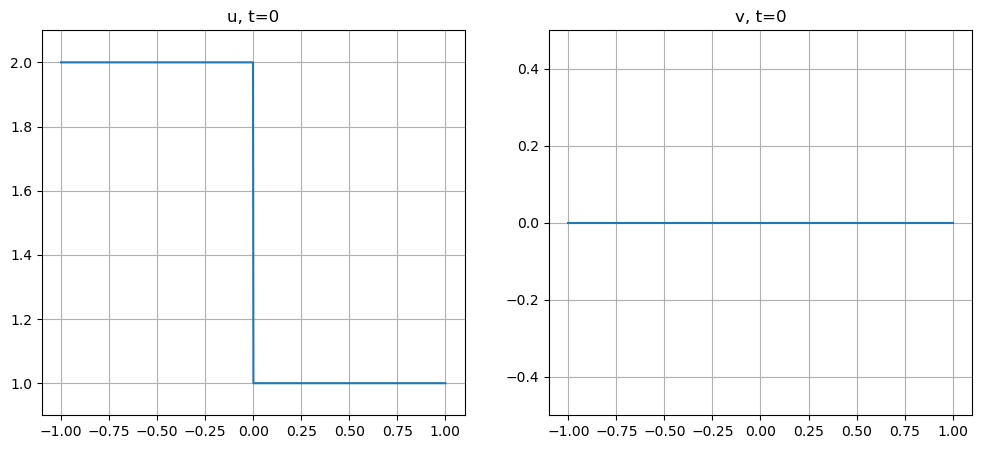

In [5]:
u0_fn = lambda x, t: jnp.select([x <= 0, x > 0], [2.0, 1.0])
v0_fn = lambda x, t: jnp.zeros_like(x)

u0_fn_ = lambda xt: jnp.select([xt[0] < 0, xt[0] > 0], [2.0, 1.0])
v0_fn_ = lambda xt: jnp.zeros_like(xt[0])

du0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 1:2]
dv0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 1:2]

du0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 0:1]
dv0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 0:1]

x0 = np.linspace(*domain[:, 0], 1000)
t0 = np.zeros_like(x0)
u0 = u0_fn(x0, t0)
v0 = v0_fn(x0, t0)

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

f, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(x0, u0)
ax[0].set_title("u, t=0")
ax[0].grid()
ax[0].set_ylim([0.9, 2.1])
ax[1].plot(x0, v0)
ax[1].set_title("v, t=0")
ax[1].grid()
ax[1].set_ylim([-0.5, 0.5])
plt.show()

key, *subkeys = random.split(key, 3)

n_i = 2000
x_i = jnp.linspace(*domain[:, 0], n_i).reshape((-1, 1))
t_i = jnp.zeros_like(x_i)
u_i = u0_fn(x_i, t_i)
v_i = v0_fn(x_i, t_i)

n_b = 2000
x_bl = jnp.ones((n_b, 1))*domain[0, 0]
x_br = jnp.ones((n_b, 1))*domain[1, 0]
t_b = jnp.linspace(*domain[:, 1], n_b).reshape((-1, 1))
x_b = jnp.vstack([x_bl, x_br])
t_b = jnp.vstack([t_b, t_b])
u_b = u0_fn(x_b, t_b)
v_b = v0_fn(x_b, t_b)

n_cx = 201
n_ct = 100
x_c = jnp.linspace(*domain[:, 0], n_cx).reshape((-1, 1))
t_c = jnp.linspace(*domain[:, 1], n_ct).reshape((-1, 1))
xt_c = tensor_grid([x_c, t_c])

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "u", "v"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t"])

dirichlet = dataset_Dirichlet(jnp.vstack([x_i, x_b]), jnp.vstack([t_i, t_b]), jnp.vstack([u_i, u_b]), jnp.vstack([v_i, v_b]))
collocation = dataset_Collocation(xt_c[:, 0:1], xt_c[:, 1:2])

In [6]:
# class Time_Marching_Generator:
# 	def __init__(self, key, spatial_points, temporal_domain, batch_size, iterations, update_every, count1 = 0):
# 		self.key = key
# 		self.spatial_points = spatial_points
# 		self.domain = temporal_domain
# 		self.batch_size = batch_size
# 		self.iterations = iterations
# 		self._count1 = count1
# 		self._count2 = update_every
# 		if count1 < iterations:
# 			self._update(self.domain[0])
# 		else:
# 			self._update(self.domain[1])
# 		self.update_every = update_every
		
# 	def _update(self, tmax):
# 		self.key, subkey = random.split(self.key)
# 		self._t = random.uniform(key, (self.batch_size, 1), jnp.float32, self.domain[0], tmax)
		
# 	def __iter__(self):
# 		return self
	
# 	def __next__(self):
# 		if self._count2 == self.update_every:
# 			self._count1 = max(self.iterations, self._count1 + 1)
# 			tmax = self.domain[0] + (self.domain[1]-self.domain[0])*self._count1/self.iterations
# 			self._update(tmax)
# 			self._count2 = 0
# 		else:
# 			self._count2 += 1
# 		return self.spatial_points, self._t

In [ ]:
lr = 1e-3
params = direct_params
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

batch_size = {"dirichlet": 4000, "collocation": 20100}
key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])

start_iteration = 0
iterations = 100000
print_every = 1000
save_every = 100000
weights = {"c1": 1.0, "c2": epsilon*10, "d": 10.0, "l1": 1e-8, "l2": 1e-8}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "d", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"collocation": dataset_Collocation(*Collocation.dataset),
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/23, 18:18:48, Iteration: 0, Train Loss: 1.8551e+01, c1: 1.8029e+00, c2: 4.9626e+10, d: 1.6252e+00, l1_reg: 2.9859e+02, l2_reg: 4.4355e+01
2020/08/23, 18:18:59, Iteration: 1000, Train Loss: 5.0153e+00, c1: 2.2034e-02, c2: 5.7432e+09, d: 4.9358e-01, l1_reg: 2.9693e+02, l2_reg: 4.4062e+01
2020/08/23, 18:19:07, Iteration: 2000, Train Loss: 2.7267e+00, c1: 1.3341e-01, c2: 2.3657e+10, d: 2.3568e-01, l1_reg: 3.2252e+02, l2_reg: 5.5516e+01
2020/08/23, 18:19:16, Iteration: 3000, Train Loss: 2.5024e+00, c1: 1.0870e-01, c2: 1.3244e+10, d: 2.2613e-01, l1_reg: 3.2383e+02, l2_reg: 5.7024e+01
2020/08/23, 18:19:24, Iteration: 4000, Train Loss: 2.4798e+00, c1: 1.3818e-01, c2: 8.0599e+09, d: 2.2610e-01, l1_reg: 3.2446e+02, l2_reg: 5.7544e+01
2020/08/23, 18:19:33, Iteration: 5000, Train Loss: 2.4600e+00, c1: 1.2429e-01, c2: 1.4275e+10, d: 2.1930e-01, l1_reg: 3.2528e+02, l2_reg: 5.8089e+01
2020/08/23, 18:19:41, Iteration: 6000, Train Loss: 2.3547e+00, c1: 2.9735e-02, c2: 1.6890e+10, d: 2.1560e-01,

2020/08/23, 18:26:37, Iteration: 55000, Train Loss: 4.2866e-01, c1: 5.4736e-02, c2: 1.9439e+10, d: 1.7953e-02, l1_reg: 4.3020e+02, l2_reg: 1.5769e+02
2020/08/23, 18:26:46, Iteration: 56000, Train Loss: 4.2578e-01, c1: 5.1110e-02, c2: 1.8901e+10, d: 1.8566e-02, l1_reg: 4.3094e+02, l2_reg: 1.5861e+02
2020/08/23, 18:26:55, Iteration: 57000, Train Loss: 3.9010e-01, c1: 3.9348e-02, c2: 1.7961e+10, d: 1.7114e-02, l1_reg: 4.3165e+02, l2_reg: 1.5961e+02
2020/08/23, 18:27:03, Iteration: 58000, Train Loss: 3.9230e-01, c1: 5.4739e-02, c2: 1.7504e+10, d: 1.6253e-02, l1_reg: 4.3244e+02, l2_reg: 1.6062e+02
2020/08/23, 18:27:11, Iteration: 59000, Train Loss: 3.8639e-01, c1: 4.3420e-02, c2: 1.6670e+10, d: 1.7626e-02, l1_reg: 4.3326e+02, l2_reg: 1.6167e+02
2020/08/23, 18:27:20, Iteration: 60000, Train Loss: 4.0605e-01, c1: 4.9830e-02, c2: 1.6865e+10, d: 1.8757e-02, l1_reg: 4.3423e+02, l2_reg: 1.6275e+02
2020/08/23, 18:27:28, Iteration: 61000, Train Loss: 3.6162e-01, c1: 4.1414e-02, c2: 1.6329e+10, d: 1

In [9]:
start_iteration = 100000
iterations = 400000
print_every = 1000
save_every = 100000
weights = {"c1": 1.0, "c2": epsilon*10, "d": 10.0, "l1": 1e-8, "l2": 1e-8}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "d", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"collocation": dataset_Collocation(*Collocation.dataset),
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/23, 18:54:01, Iteration: 100000, Train Loss: 2.7572e-01, c1: 2.9589e-02, c2: 1.1220e+10, d: 1.3393e-02, l1_reg: 4.5300e+02, l2_reg: 1.9318e+02
2020/08/23, 18:54:10, Iteration: 101000, Train Loss: 3.2617e-01, c1: 3.7330e-02, c2: 1.2753e+10, d: 1.6131e-02, l1_reg: 4.5323e+02, l2_reg: 1.9374e+02
2020/08/23, 18:54:18, Iteration: 102000, Train Loss: 3.0708e-01, c1: 3.0872e-02, c2: 1.2404e+10, d: 1.5217e-02, l1_reg: 4.5357e+02, l2_reg: 1.9439e+02
2020/08/23, 18:54:27, Iteration: 103000, Train Loss: 2.8378e-01, c1: 3.3849e-02, c2: 1.2827e+10, d: 1.2166e-02, l1_reg: 4.5391e+02, l2_reg: 1.9506e+02
2020/08/23, 18:54:35, Iteration: 104000, Train Loss: 3.1431e-01, c1: 3.3942e-02, c2: 1.2534e+10, d: 1.5502e-02, l1_reg: 4.5425e+02, l2_reg: 1.9574e+02
2020/08/23, 18:54:43, Iteration: 105000, Train Loss: 2.8786e-01, c1: 3.5185e-02, c2: 1.1704e+10, d: 1.3564e-02, l1_reg: 4.5463e+02, l2_reg: 1.9638e+02
2020/08/23, 18:54:52, Iteration: 106000, Train Loss: 2.8188e-01, c1: 2.8789e-02, c2: 1.0845e+1

2020/08/23, 19:01:45, Iteration: 155000, Train Loss: 2.9907e-01, c1: 2.7198e-02, c2: 1.0789e+10, d: 1.6399e-02, l1_reg: 4.7567e+02, l2_reg: 2.2698e+02
2020/08/23, 19:01:53, Iteration: 156000, Train Loss: 2.4034e-01, c1: 1.8916e-02, c2: 1.0458e+10, d: 1.1685e-02, l1_reg: 4.7606e+02, l2_reg: 2.2737e+02
2020/08/23, 19:02:02, Iteration: 157000, Train Loss: 3.1225e-01, c1: 5.9312e-02, c2: 1.3166e+10, d: 1.2128e-02, l1_reg: 4.7614e+02, l2_reg: 2.2784e+02
2020/08/23, 19:02:10, Iteration: 158000, Train Loss: 2.4622e-01, c1: 2.6013e-02, c2: 1.0643e+10, d: 1.1378e-02, l1_reg: 4.7634e+02, l2_reg: 2.2832e+02
2020/08/23, 19:02:18, Iteration: 159000, Train Loss: 2.5861e-01, c1: 2.7143e-02, c2: 1.1239e+10, d: 1.1908e-02, l1_reg: 4.7673e+02, l2_reg: 2.2880e+02
2020/08/23, 19:02:27, Iteration: 160000, Train Loss: 2.9567e-01, c1: 2.9307e-02, c2: 1.0295e+10, d: 1.6341e-02, l1_reg: 4.7695e+02, l2_reg: 2.2922e+02
2020/08/23, 19:02:35, Iteration: 161000, Train Loss: 2.7309e-01, c1: 2.5351e-02, c2: 1.0384e+1

2020/08/23, 19:09:30, Iteration: 210000, Train Loss: 2.8909e-01, c1: 3.7185e-02, c2: 1.2178e+10, d: 1.3013e-02, l1_reg: 4.8937e+02, l2_reg: 2.5444e+02
2020/08/23, 19:09:38, Iteration: 211000, Train Loss: 2.3735e-01, c1: 2.5843e-02, c2: 1.0175e+10, d: 1.0976e-02, l1_reg: 4.8946e+02, l2_reg: 2.5495e+02
2020/08/23, 19:09:47, Iteration: 212000, Train Loss: 2.3169e-01, c1: 2.9754e-02, c2: 9.6873e+09, d: 1.0506e-02, l1_reg: 4.8956e+02, l2_reg: 2.5541e+02
2020/08/23, 19:09:55, Iteration: 213000, Train Loss: 2.3211e-01, c1: 2.6494e-02, c2: 9.9689e+09, d: 1.0592e-02, l1_reg: 4.8983e+02, l2_reg: 2.5586e+02
2020/08/23, 19:10:04, Iteration: 214000, Train Loss: 2.4561e-01, c1: 2.9382e-02, c2: 1.1112e+10, d: 1.0511e-02, l1_reg: 4.8986e+02, l2_reg: 2.5619e+02
2020/08/23, 19:10:12, Iteration: 215000, Train Loss: 2.3018e-01, c1: 2.5466e-02, c2: 9.6577e+09, d: 1.0814e-02, l1_reg: 4.8996e+02, l2_reg: 2.5666e+02
2020/08/23, 19:10:21, Iteration: 216000, Train Loss: 2.3473e-01, c1: 4.3771e-02, c2: 8.9213e+0

2020/08/23, 19:17:15, Iteration: 265000, Train Loss: 2.0861e-01, c1: 3.8183e-02, c2: 8.6846e+09, d: 8.3579e-03, l1_reg: 4.9114e+02, l2_reg: 2.7274e+02
2020/08/23, 19:17:23, Iteration: 266000, Train Loss: 2.3588e-01, c1: 2.6871e-02, c2: 1.0050e+10, d: 1.0851e-02, l1_reg: 4.9074e+02, l2_reg: 2.7294e+02
2020/08/23, 19:17:32, Iteration: 267000, Train Loss: 2.1861e-01, c1: 2.7442e-02, c2: 9.1758e+09, d: 9.9410e-03, l1_reg: 4.9092e+02, l2_reg: 2.7314e+02
2020/08/23, 19:17:40, Iteration: 268000, Train Loss: 2.3544e-01, c1: 3.0173e-02, c2: 9.8041e+09, d: 1.0722e-02, l1_reg: 4.9090e+02, l2_reg: 2.7342e+02
2020/08/23, 19:17:49, Iteration: 269000, Train Loss: 2.2301e-01, c1: 2.3933e-02, c2: 9.7198e+09, d: 1.0187e-02, l1_reg: 4.9115e+02, l2_reg: 2.7374e+02
2020/08/23, 19:17:57, Iteration: 270000, Train Loss: 2.3391e-01, c1: 3.9012e-02, c2: 8.9948e+09, d: 1.0495e-02, l1_reg: 4.9126e+02, l2_reg: 2.7392e+02
2020/08/23, 19:18:06, Iteration: 271000, Train Loss: 2.2827e-01, c1: 4.1494e-02, c2: 8.9820e+0

2020/08/23, 19:25:03, Iteration: 320000, Train Loss: 2.1217e-01, c1: 3.3782e-02, c2: 9.4965e+09, d: 8.3419e-03, l1_reg: 4.9597e+02, l2_reg: 2.8462e+02
2020/08/23, 19:25:11, Iteration: 321000, Train Loss: 2.0676e-01, c1: 2.6717e-02, c2: 9.4546e+09, d: 8.5499e-03, l1_reg: 4.9614e+02, l2_reg: 2.8476e+02
2020/08/23, 19:25:20, Iteration: 322000, Train Loss: 2.1275e-01, c1: 3.3065e-02, c2: 8.6997e+09, d: 9.2688e-03, l1_reg: 4.9608e+02, l2_reg: 2.8497e+02
2020/08/23, 19:25:28, Iteration: 323000, Train Loss: 2.0994e-01, c1: 2.9776e-02, c2: 9.3519e+09, d: 8.6643e-03, l1_reg: 4.9656e+02, l2_reg: 2.8514e+02
2020/08/23, 19:25:37, Iteration: 324000, Train Loss: 2.2484e-01, c1: 3.1796e-02, c2: 1.0351e+10, d: 8.9536e-03, l1_reg: 4.9632e+02, l2_reg: 2.8535e+02
2020/08/23, 19:25:45, Iteration: 325000, Train Loss: 1.9330e-01, c1: 2.5508e-02, c2: 8.4713e+09, d: 8.3075e-03, l1_reg: 4.9662e+02, l2_reg: 2.8561e+02
2020/08/23, 19:25:53, Iteration: 326000, Train Loss: 2.0901e-01, c1: 3.3553e-02, c2: 8.5768e+0

2020/08/23, 19:32:48, Iteration: 375000, Train Loss: 1.9313e-01, c1: 1.8561e-02, c2: 8.2823e+09, d: 9.1748e-03, l1_reg: 4.9981e+02, l2_reg: 2.9591e+02
2020/08/23, 19:32:57, Iteration: 376000, Train Loss: 1.9595e-01, c1: 3.1717e-02, c2: 8.4242e+09, d: 7.9994e-03, l1_reg: 4.9991e+02, l2_reg: 2.9603e+02
2020/08/23, 19:33:05, Iteration: 377000, Train Loss: 2.0069e-01, c1: 3.5716e-02, c2: 8.1931e+09, d: 8.3042e-03, l1_reg: 5.0002e+02, l2_reg: 2.9625e+02
2020/08/23, 19:33:14, Iteration: 378000, Train Loss: 2.1533e-01, c1: 2.9638e-02, c2: 7.8648e+09, d: 1.0704e-02, l1_reg: 5.0014e+02, l2_reg: 2.9639e+02
2020/08/23, 19:33:22, Iteration: 379000, Train Loss: 1.9923e-01, c1: 2.8212e-02, c2: 8.8055e+09, d: 8.2961e-03, l1_reg: 5.0007e+02, l2_reg: 2.9655e+02
2020/08/23, 19:33:31, Iteration: 380000, Train Loss: 1.9852e-01, c1: 2.7712e-02, c2: 8.6099e+09, d: 8.4705e-03, l1_reg: 5.0057e+02, l2_reg: 2.9681e+02
2020/08/23, 19:33:39, Iteration: 381000, Train Loss: 1.8658e-01, c1: 2.5857e-02, c2: 7.8404e+0

2020/08/23, 19:40:36, Iteration: 430000, Train Loss: 1.8835e-01, c1: 2.4830e-02, c2: 8.5926e+09, d: 7.7593e-03, l1_reg: 5.0570e+02, l2_reg: 3.0743e+02
2020/08/23, 19:40:45, Iteration: 431000, Train Loss: 1.8220e-01, c1: 2.2374e-02, c2: 8.4189e+09, d: 7.5633e-03, l1_reg: 5.0543e+02, l2_reg: 3.0766e+02
2020/08/23, 19:40:53, Iteration: 432000, Train Loss: 1.9274e-01, c1: 2.2803e-02, c2: 8.7470e+09, d: 8.2462e-03, l1_reg: 5.0593e+02, l2_reg: 3.0790e+02
2020/08/23, 19:41:02, Iteration: 433000, Train Loss: 2.2275e-01, c1: 3.6089e-02, c2: 9.9878e+09, d: 8.6785e-03, l1_reg: 5.0589e+02, l2_reg: 3.0817e+02
2020/08/23, 19:41:10, Iteration: 434000, Train Loss: 2.0675e-01, c1: 3.1687e-02, c2: 8.2624e+09, d: 9.2438e-03, l1_reg: 5.0579e+02, l2_reg: 3.0832e+02
2020/08/23, 19:41:19, Iteration: 435000, Train Loss: 1.9153e-01, c1: 2.5601e-02, c2: 8.7819e+09, d: 7.8106e-03, l1_reg: 5.0618e+02, l2_reg: 3.0858e+02
2020/08/23, 19:41:27, Iteration: 436000, Train Loss: 1.9172e-01, c1: 2.4609e-02, c2: 8.7842e+0

2020/08/23, 19:48:23, Iteration: 485000, Train Loss: 1.8287e-01, c1: 2.4048e-02, c2: 8.3939e+09, d: 7.4881e-03, l1_reg: 5.0871e+02, l2_reg: 3.2051e+02
2020/08/23, 19:48:31, Iteration: 486000, Train Loss: 2.0111e-01, c1: 3.5454e-02, c2: 8.9485e+09, d: 7.6167e-03, l1_reg: 5.0878e+02, l2_reg: 3.2076e+02
2020/08/23, 19:48:40, Iteration: 487000, Train Loss: 1.9345e-01, c1: 2.3470e-02, c2: 8.7485e+09, d: 8.2500e-03, l1_reg: 5.0863e+02, l2_reg: 3.2100e+02
2020/08/23, 19:48:48, Iteration: 488000, Train Loss: 2.1507e-01, c1: 2.7419e-02, c2: 9.8044e+09, d: 8.9612e-03, l1_reg: 5.0846e+02, l2_reg: 3.2117e+02
2020/08/23, 19:48:56, Iteration: 489000, Train Loss: 1.9138e-01, c1: 2.1654e-02, c2: 8.3853e+09, d: 8.5873e-03, l1_reg: 5.0853e+02, l2_reg: 3.2148e+02
2020/08/23, 19:49:05, Iteration: 490000, Train Loss: 1.8174e-01, c1: 3.0026e-02, c2: 7.6287e+09, d: 7.5424e-03, l1_reg: 5.0871e+02, l2_reg: 3.2180e+02
2020/08/23, 19:49:13, Iteration: 491000, Train Loss: 1.8142e-01, c1: 2.4598e-02, c2: 8.3778e+0

In [11]:
start_iteration = 500000
iterations = 500000
print_every = 1000
save_every = 100000
weights = {"c1": 1.0, "c2": epsilon*10, "d": 10.0, "l1": 1e-10, "l2": 1e-10}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "d", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"collocation": dataset_Collocation(*Collocation.dataset),
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/23, 19:54:23, Iteration: 500000, Train Loss: 1.8113e-01, c1: 2.7121e-02, c2: 8.2264e+09, d: 7.1743e-03, l1_reg: 5.0837e+02, l2_reg: 3.2421e+02
2020/08/23, 19:54:32, Iteration: 501000, Train Loss: 1.8662e-01, c1: 2.4189e-02, c2: 8.1611e+09, d: 8.0822e-03, l1_reg: 5.0818e+02, l2_reg: 3.2437e+02
2020/08/23, 19:54:40, Iteration: 502000, Train Loss: 1.8593e-01, c1: 2.4556e-02, c2: 8.8026e+09, d: 7.3343e-03, l1_reg: 5.0831e+02, l2_reg: 3.2461e+02
2020/08/23, 19:54:49, Iteration: 503000, Train Loss: 2.0321e-01, c1: 2.4044e-02, c2: 8.4537e+09, d: 9.4629e-03, l1_reg: 5.0803e+02, l2_reg: 3.2483e+02
2020/08/23, 19:54:57, Iteration: 504000, Train Loss: 1.9086e-01, c1: 2.3237e-02, c2: 9.0235e+09, d: 7.7385e-03, l1_reg: 5.0816e+02, l2_reg: 3.2504e+02
2020/08/23, 19:55:06, Iteration: 505000, Train Loss: 1.7752e-01, c1: 1.7041e-02, c2: 8.4989e+09, d: 7.5491e-03, l1_reg: 5.0841e+02, l2_reg: 3.2528e+02
2020/08/23, 19:55:14, Iteration: 506000, Train Loss: 1.6694e-01, c1: 1.8882e-02, c2: 7.9475e+0

2020/08/23, 20:02:11, Iteration: 555000, Train Loss: 1.6496e-01, c1: 2.0462e-02, c2: 7.8776e+09, d: 6.5720e-03, l1_reg: 5.0369e+02, l2_reg: 3.3636e+02
2020/08/23, 20:02:19, Iteration: 556000, Train Loss: 1.9233e-01, c1: 3.5377e-02, c2: 8.6245e+09, d: 7.0709e-03, l1_reg: 5.0368e+02, l2_reg: 3.3649e+02
2020/08/23, 20:02:28, Iteration: 557000, Train Loss: 1.6934e-01, c1: 2.1514e-02, c2: 8.0661e+09, d: 6.7166e-03, l1_reg: 5.0343e+02, l2_reg: 3.3675e+02
2020/08/23, 20:02:36, Iteration: 558000, Train Loss: 1.9219e-01, c1: 3.0297e-02, c2: 8.4908e+09, d: 7.6981e-03, l1_reg: 5.0339e+02, l2_reg: 3.3698e+02
2020/08/23, 20:02:45, Iteration: 559000, Train Loss: 1.8084e-01, c1: 2.5342e-02, c2: 8.6449e+09, d: 6.9052e-03, l1_reg: 5.0345e+02, l2_reg: 3.3722e+02
2020/08/23, 20:02:53, Iteration: 560000, Train Loss: 1.8111e-01, c1: 2.5999e-02, c2: 8.2668e+09, d: 7.2438e-03, l1_reg: 5.0347e+02, l2_reg: 3.3747e+02
2020/08/23, 20:03:02, Iteration: 561000, Train Loss: 2.0441e-01, c1: 3.0124e-02, c2: 9.5749e+0

2020/08/23, 20:09:57, Iteration: 610000, Train Loss: 1.7989e-01, c1: 2.4933e-02, c2: 7.8866e+09, d: 7.6086e-03, l1_reg: 4.9957e+02, l2_reg: 3.4875e+02
2020/08/23, 20:10:05, Iteration: 611000, Train Loss: 1.7601e-01, c1: 2.6351e-02, c2: 8.3530e+09, d: 6.6134e-03, l1_reg: 4.9988e+02, l2_reg: 3.4904e+02
2020/08/23, 20:10:14, Iteration: 612000, Train Loss: 1.8192e-01, c1: 2.7014e-02, c2: 8.7855e+09, d: 6.7046e-03, l1_reg: 5.0004e+02, l2_reg: 3.4925e+02
2020/08/23, 20:10:22, Iteration: 613000, Train Loss: 2.0503e-01, c1: 3.8654e-02, c2: 9.2167e+09, d: 7.4214e-03, l1_reg: 4.9994e+02, l2_reg: 3.4945e+02
2020/08/23, 20:10:31, Iteration: 614000, Train Loss: 1.7390e-01, c1: 2.3734e-02, c2: 8.5079e+09, d: 6.5091e-03, l1_reg: 5.0015e+02, l2_reg: 3.4972e+02
2020/08/23, 20:10:39, Iteration: 615000, Train Loss: 1.7622e-01, c1: 2.7232e-02, c2: 7.8668e+09, d: 7.0317e-03, l1_reg: 4.9981e+02, l2_reg: 3.4998e+02
2020/08/23, 20:10:48, Iteration: 616000, Train Loss: 1.8308e-01, c1: 2.7434e-02, c2: 8.2345e+0

2020/08/23, 20:17:42, Iteration: 665000, Train Loss: 1.7389e-01, c1: 2.6368e-02, c2: 8.3598e+09, d: 6.3927e-03, l1_reg: 4.9975e+02, l2_reg: 3.6308e+02
2020/08/23, 20:17:50, Iteration: 666000, Train Loss: 1.6858e-01, c1: 2.3731e-02, c2: 7.7706e+09, d: 6.7145e-03, l1_reg: 5.0011e+02, l2_reg: 3.6333e+02
2020/08/23, 20:17:59, Iteration: 667000, Train Loss: 1.6562e-01, c1: 2.5144e-02, c2: 7.8796e+09, d: 6.1677e-03, l1_reg: 5.0009e+02, l2_reg: 3.6363e+02
2020/08/23, 20:18:07, Iteration: 668000, Train Loss: 1.9073e-01, c1: 2.5168e-02, c2: 9.7262e+09, d: 6.8298e-03, l1_reg: 4.9997e+02, l2_reg: 3.6388e+02
2020/08/23, 20:18:15, Iteration: 669000, Train Loss: 1.6987e-01, c1: 2.5165e-02, c2: 8.5708e+09, d: 5.8999e-03, l1_reg: 5.0002e+02, l2_reg: 3.6413e+02
2020/08/23, 20:18:24, Iteration: 670000, Train Loss: 1.9465e-01, c1: 4.0050e-02, c2: 8.4467e+09, d: 7.0138e-03, l1_reg: 4.9973e+02, l2_reg: 3.6430e+02
2020/08/23, 20:18:32, Iteration: 671000, Train Loss: 1.7754e-01, c1: 2.6298e-02, c2: 7.8428e+0

2020/08/23, 20:25:26, Iteration: 720000, Train Loss: 1.8758e-01, c1: 2.7204e-02, c2: 8.6320e+09, d: 7.4051e-03, l1_reg: 4.9502e+02, l2_reg: 3.7661e+02
2020/08/23, 20:25:35, Iteration: 721000, Train Loss: 1.5750e-01, c1: 2.2516e-02, c2: 7.6346e+09, d: 5.8636e-03, l1_reg: 4.9514e+02, l2_reg: 3.7686e+02
2020/08/23, 20:25:43, Iteration: 722000, Train Loss: 1.8849e-01, c1: 3.0707e-02, c2: 8.5891e+09, d: 7.1891e-03, l1_reg: 4.9456e+02, l2_reg: 3.7709e+02
2020/08/23, 20:25:52, Iteration: 723000, Train Loss: 1.5766e-01, c1: 2.0022e-02, c2: 7.6627e+09, d: 6.1008e-03, l1_reg: 4.9444e+02, l2_reg: 3.7741e+02
2020/08/23, 20:26:00, Iteration: 724000, Train Loss: 1.6052e-01, c1: 2.0383e-02, c2: 8.1557e+09, d: 5.8585e-03, l1_reg: 4.9411e+02, l2_reg: 3.7763e+02
2020/08/23, 20:26:09, Iteration: 725000, Train Loss: 1.7458e-01, c1: 2.3959e-02, c2: 8.1762e+09, d: 6.8858e-03, l1_reg: 4.9411e+02, l2_reg: 3.7788e+02
2020/08/23, 20:26:17, Iteration: 726000, Train Loss: 1.8054e-01, c1: 2.9651e-02, c2: 8.5394e+0

2020/08/23, 20:33:11, Iteration: 775000, Train Loss: 1.6197e-01, c1: 2.2667e-02, c2: 7.4646e+09, d: 6.4654e-03, l1_reg: 4.9167e+02, l2_reg: 3.9142e+02
2020/08/23, 20:33:20, Iteration: 776000, Train Loss: 1.6804e-01, c1: 2.7502e-02, c2: 7.6921e+09, d: 6.3617e-03, l1_reg: 4.9212e+02, l2_reg: 3.9169e+02
2020/08/23, 20:33:28, Iteration: 777000, Train Loss: 1.6493e-01, c1: 2.7079e-02, c2: 7.4657e+09, d: 6.3194e-03, l1_reg: 4.9179e+02, l2_reg: 3.9197e+02
2020/08/23, 20:33:37, Iteration: 778000, Train Loss: 1.6388e-01, c1: 2.3666e-02, c2: 7.7006e+09, d: 6.3213e-03, l1_reg: 4.9126e+02, l2_reg: 3.9225e+02
2020/08/23, 20:33:45, Iteration: 779000, Train Loss: 1.5638e-01, c1: 2.4896e-02, c2: 7.1493e+09, d: 5.9993e-03, l1_reg: 4.9168e+02, l2_reg: 3.9260e+02
2020/08/23, 20:33:53, Iteration: 780000, Train Loss: 1.6386e-01, c1: 2.4557e-02, c2: 7.8075e+09, d: 6.1233e-03, l1_reg: 4.9124e+02, l2_reg: 3.9287e+02
2020/08/23, 20:34:02, Iteration: 781000, Train Loss: 1.5892e-01, c1: 1.9641e-02, c2: 7.5256e+0

2020/08/23, 20:40:56, Iteration: 830000, Train Loss: 1.4680e-01, c1: 1.8335e-02, c2: 7.0579e+09, d: 5.7884e-03, l1_reg: 4.9106e+02, l2_reg: 4.0738e+02
2020/08/23, 20:41:04, Iteration: 831000, Train Loss: 1.7348e-01, c1: 2.5517e-02, c2: 8.6421e+09, d: 6.1539e-03, l1_reg: 4.9171e+02, l2_reg: 4.0775e+02
2020/08/23, 20:41:13, Iteration: 832000, Train Loss: 1.5989e-01, c1: 2.3531e-02, c2: 6.9676e+09, d: 6.6681e-03, l1_reg: 4.9153e+02, l2_reg: 4.0804e+02
2020/08/23, 20:41:21, Iteration: 833000, Train Loss: 1.7872e-01, c1: 3.6083e-02, c2: 7.8098e+09, d: 6.4535e-03, l1_reg: 4.9116e+02, l2_reg: 4.0824e+02
2020/08/23, 20:41:29, Iteration: 834000, Train Loss: 1.8005e-01, c1: 2.8981e-02, c2: 8.2838e+09, d: 6.8235e-03, l1_reg: 4.9206e+02, l2_reg: 4.0863e+02
2020/08/23, 20:41:38, Iteration: 835000, Train Loss: 1.5916e-01, c1: 2.3977e-02, c2: 7.7262e+09, d: 5.7924e-03, l1_reg: 4.9187e+02, l2_reg: 4.0891e+02
2020/08/23, 20:41:47, Iteration: 836000, Train Loss: 1.6300e-01, c1: 2.2329e-02, c2: 7.8080e+0

2020/08/23, 20:48:41, Iteration: 885000, Train Loss: 1.7150e-01, c1: 2.8620e-02, c2: 8.1488e+09, d: 6.1396e-03, l1_reg: 4.9508e+02, l2_reg: 4.2520e+02
2020/08/23, 20:48:50, Iteration: 886000, Train Loss: 1.6089e-01, c1: 2.2157e-02, c2: 7.5779e+09, d: 6.2954e-03, l1_reg: 4.9526e+02, l2_reg: 4.2559e+02
2020/08/23, 20:48:58, Iteration: 887000, Train Loss: 1.5867e-01, c1: 2.3327e-02, c2: 7.2038e+09, d: 6.3302e-03, l1_reg: 4.9446e+02, l2_reg: 4.2593e+02
2020/08/23, 20:49:07, Iteration: 888000, Train Loss: 1.4175e-01, c1: 2.1435e-02, c2: 6.6957e+09, d: 5.3353e-03, l1_reg: 4.9509e+02, l2_reg: 4.2633e+02
2020/08/23, 20:49:15, Iteration: 889000, Train Loss: 1.6431e-01, c1: 2.7250e-02, c2: 7.7397e+09, d: 5.9661e-03, l1_reg: 4.9536e+02, l2_reg: 4.2673e+02
2020/08/23, 20:49:24, Iteration: 890000, Train Loss: 1.6679e-01, c1: 2.9457e-02, c2: 7.7535e+09, d: 5.9797e-03, l1_reg: 4.9492e+02, l2_reg: 4.2695e+02
2020/08/23, 20:49:32, Iteration: 891000, Train Loss: 1.4759e-01, c1: 1.9894e-02, c2: 6.8847e+0

2020/08/23, 20:56:28, Iteration: 940000, Train Loss: 1.5699e-01, c1: 1.9281e-02, c2: 7.5755e+09, d: 6.1958e-03, l1_reg: 5.0009e+02, l2_reg: 4.4582e+02
2020/08/23, 20:56:36, Iteration: 941000, Train Loss: 1.5665e-01, c1: 3.2395e-02, c2: 7.2514e+09, d: 5.1745e-03, l1_reg: 5.0135e+02, l2_reg: 4.4621e+02
2020/08/23, 20:56:45, Iteration: 942000, Train Loss: 1.6535e-01, c1: 2.4057e-02, c2: 7.9164e+09, d: 6.2125e-03, l1_reg: 5.0059e+02, l2_reg: 4.4663e+02
2020/08/23, 20:56:53, Iteration: 943000, Train Loss: 1.6207e-01, c1: 2.1063e-02, c2: 7.4286e+09, d: 6.6725e-03, l1_reg: 5.0036e+02, l2_reg: 4.4703e+02
2020/08/23, 20:57:02, Iteration: 944000, Train Loss: 1.5358e-01, c1: 1.6717e-02, c2: 6.7943e+09, d: 6.8923e-03, l1_reg: 5.0057e+02, l2_reg: 4.4752e+02
2020/08/23, 20:57:10, Iteration: 945000, Train Loss: 1.4857e-01, c1: 2.9409e-02, c2: 6.7749e+09, d: 5.1410e-03, l1_reg: 5.0039e+02, l2_reg: 4.4794e+02
2020/08/23, 20:57:19, Iteration: 946000, Train Loss: 1.5955e-01, c1: 2.4250e-02, c2: 7.1540e+0

2020/08/23, 21:04:12, Iteration: 995000, Train Loss: 1.5504e-01, c1: 2.2827e-02, c2: 7.5715e+09, d: 5.6496e-03, l1_reg: 5.0789e+02, l2_reg: 4.7309e+02
2020/08/23, 21:04:20, Iteration: 996000, Train Loss: 1.8008e-01, c1: 3.1350e-02, c2: 8.9272e+09, d: 5.9459e-03, l1_reg: 5.0686e+02, l2_reg: 4.7361e+02
2020/08/23, 21:04:29, Iteration: 997000, Train Loss: 1.4334e-01, c1: 1.6973e-02, c2: 7.2581e+09, d: 5.3790e-03, l1_reg: 5.0677e+02, l2_reg: 4.7405e+02
2020/08/23, 21:04:37, Iteration: 998000, Train Loss: 1.5478e-01, c1: 2.2685e-02, c2: 7.6103e+09, d: 5.5992e-03, l1_reg: 5.0760e+02, l2_reg: 4.7462e+02
2020/08/23, 21:04:45, Iteration: 999000, Train Loss: 1.6126e-01, c1: 2.4033e-02, c2: 8.0944e+09, d: 5.6287e-03, l1_reg: 5.0710e+02, l2_reg: 4.7520e+02
2020/08/23, 21:04:54, Iteration: 1000000, Train Loss: 1.5656e-01, c1: 2.1717e-02, c2: 8.0010e+09, d: 5.4833e-03, l1_reg: 5.0702e+02, l2_reg: 4.7567e+02


<IPython.core.display.Javascript object>


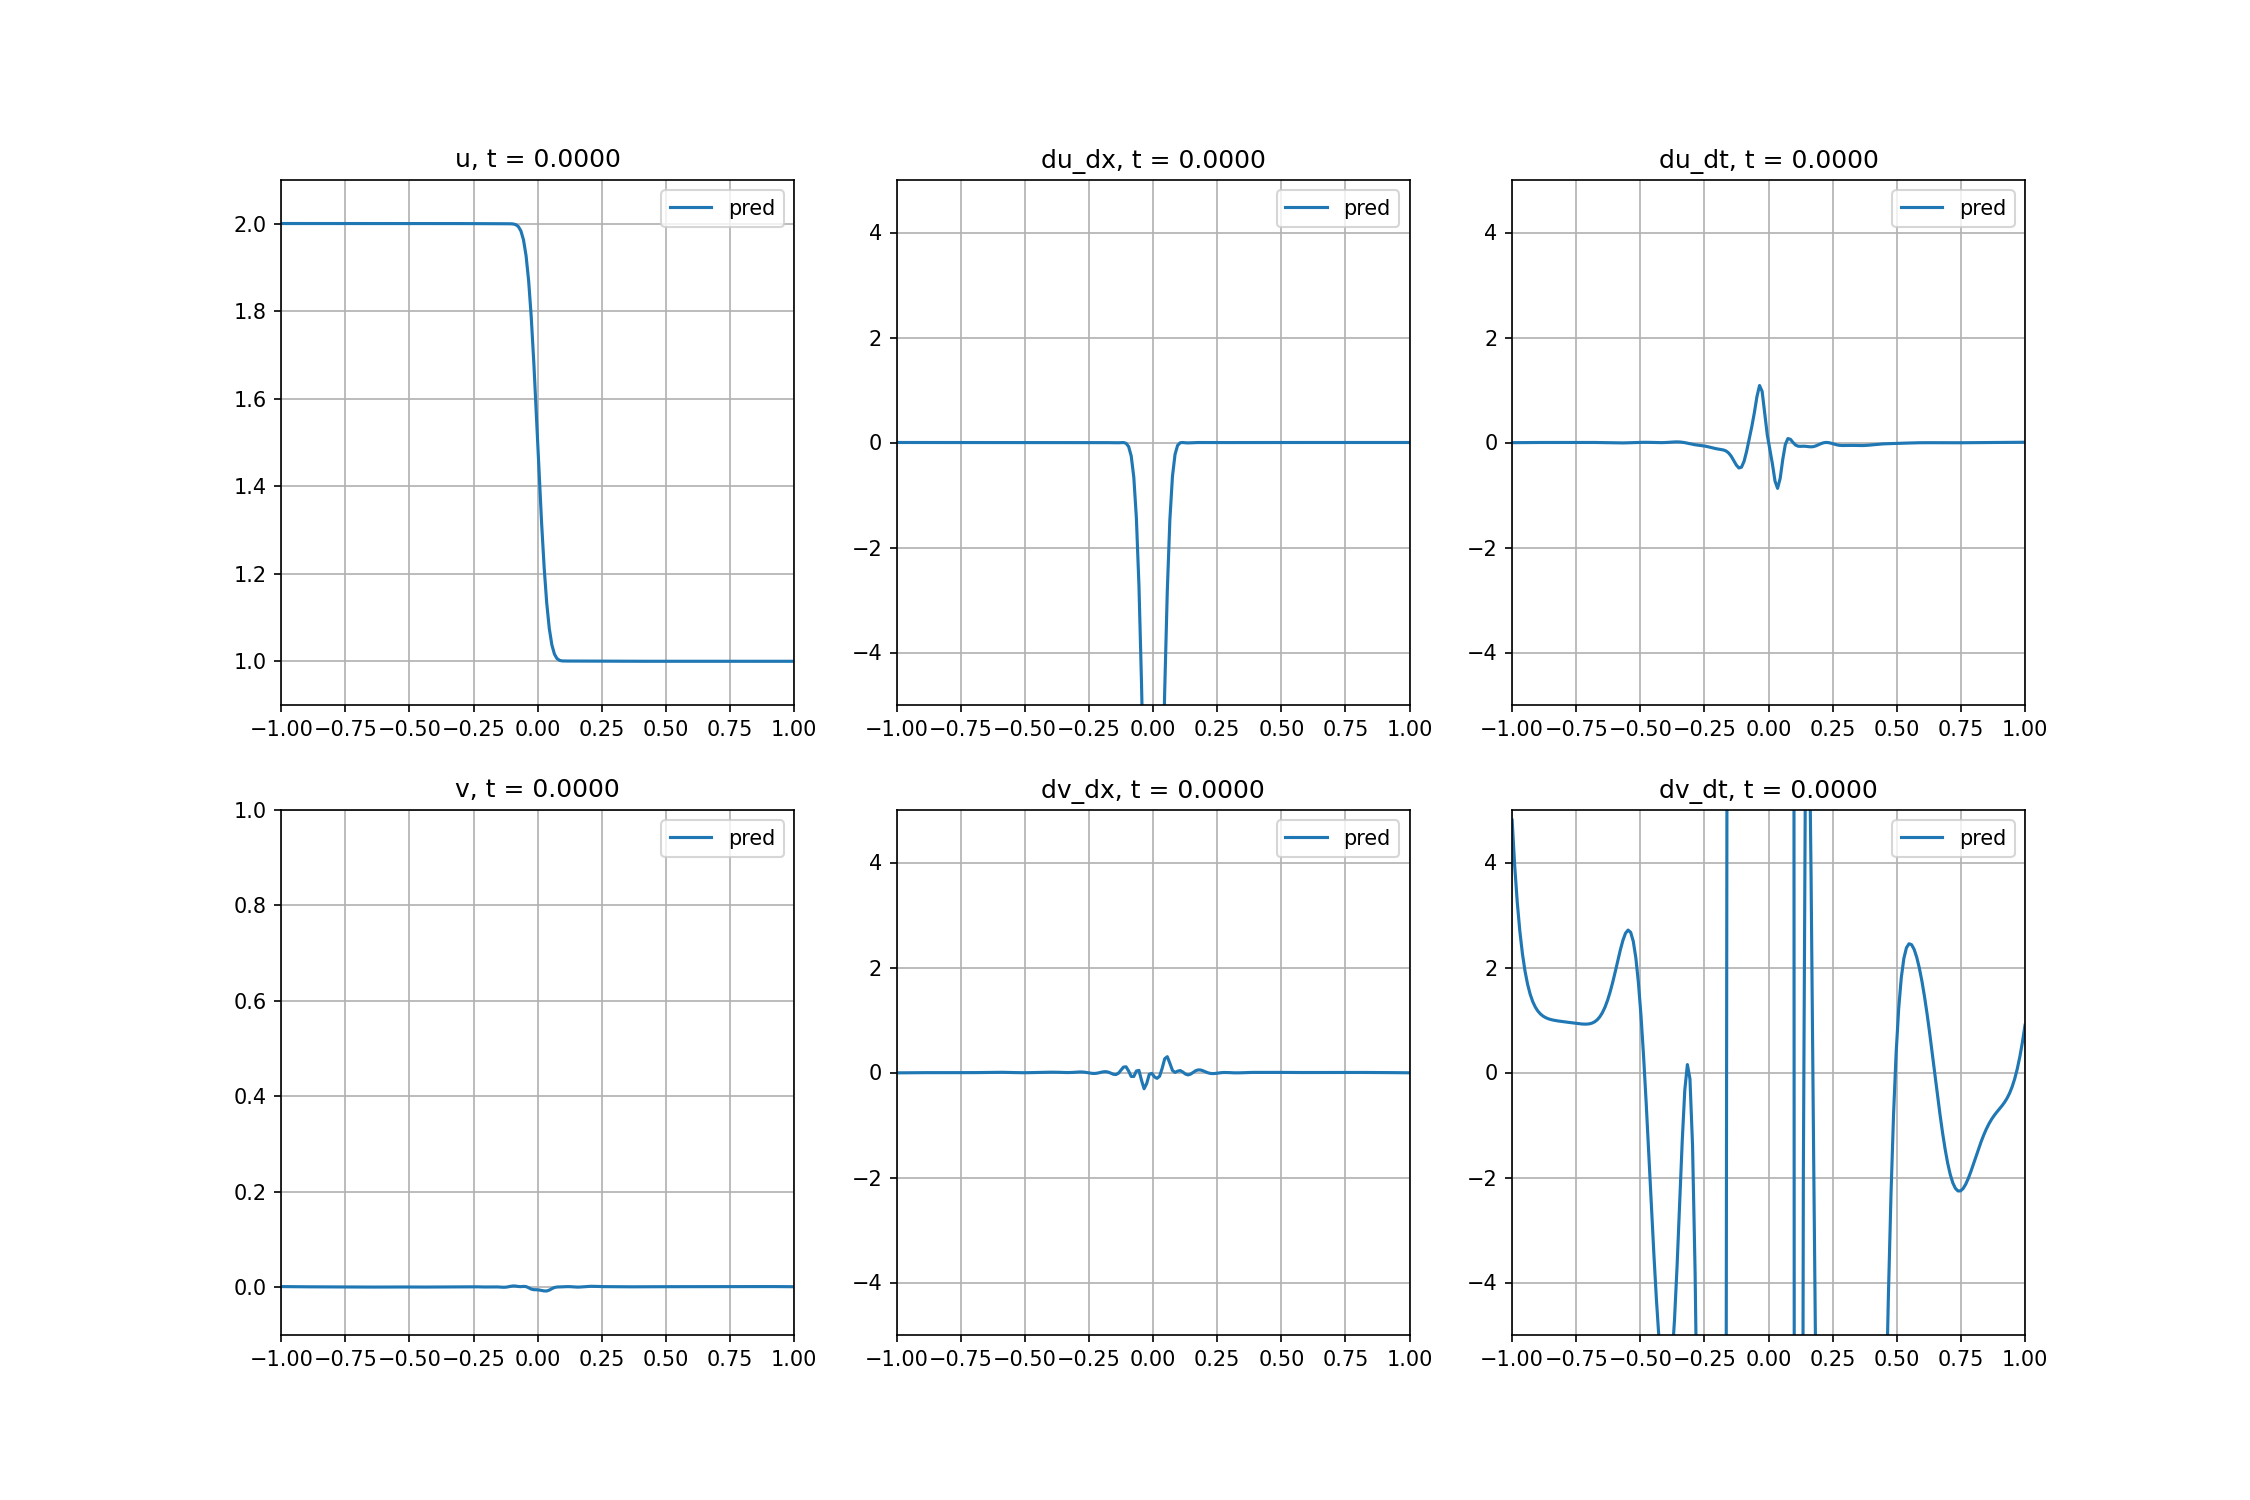

In [15]:
params_ = get_params(opt_state)

x_test = jnp.linspace(*domain[:, 0], 200)
t_test = jnp.linspace(*domain[:, 1], 200)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]
uv_preds = [model(params_, xt_test) for xt_test in xt_tests]
u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]
duv_dxt_preds = [jacobian(params_, xt_test) for xt_test in xt_tests]
du_dx_preds, dv_dx_preds = [duv_dxt_pred[:, 0:1, 0] for duv_dxt_pred in duv_dxt_preds], [duv_dxt_pred[:, 1:2, 0] for duv_dxt_pred in duv_dxt_preds]
du_dt_preds, dv_dt_preds = [duv_dxt_pred[:, 0:1, 1] for duv_dxt_pred in duv_dxt_preds], [duv_dxt_pred[:, 1:2, 1] for duv_dxt_pred in duv_dxt_preds]


from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(2, 3, figsize = (15, 10))
lines = []
for i in range(2):
	for j in range(3):
		line, = ax[i][j].plot([], [], lw = 1.5, label = "pred")
		lines.append(line)
		ax[i][j].set_xlim([-1, 1])
		ax[i][j].set_ylim([-5, 5])
		ax[i][j].legend()
		ax[i][j].grid()
ax[0][0].set_ylim([0.9, 2.1])
ax[1][0].set_ylim([-0.1, 1.0])
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

def animate(i):
	u_pred, v_pred = u_preds[i], v_preds[i]
	du_dx_pred, dv_dx_pred = du_dx_preds[i], dv_dx_preds[i]
	du_dt_pred, dv_dt_pred = du_dt_preds[i], dv_dt_preds[i]
# 	u_true, v_true = np.real(uv_true[i, :]), np.imag(uv_true[i, :])
	
	lines[0].set_data(x_test, u_pred)
	ax[0][0].set_title("u, t = {:.4f}".format(t_test[i]))
	lines[1].set_data(x_test, du_dx_pred)
	ax[0][1].set_title("du_dx, t = {:.4f}".format(t_test[i]))
	lines[2].set_data(x_test, du_dt_pred)
	ax[0][2].set_title("du_dt, t = {:.4f}".format(t_test[i]))
    
	lines[3].set_data(x_test, v_pred)
	ax[1][0].set_title("v, t = {:.4f}".format(t_test[i]))
	lines[4].set_data(x_test, dv_dx_pred)
	ax[1][1].set_title("dv_dx, t = {:.4f}".format(t_test[i]))
	lines[5].set_data(x_test, dv_dt_pred)
	ax[1][2].set_title("dv_dt, t = {:.4f}".format(t_test[i]))

	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 50, blit = True)
plt.show()

<IPython.core.display.Javascript object>


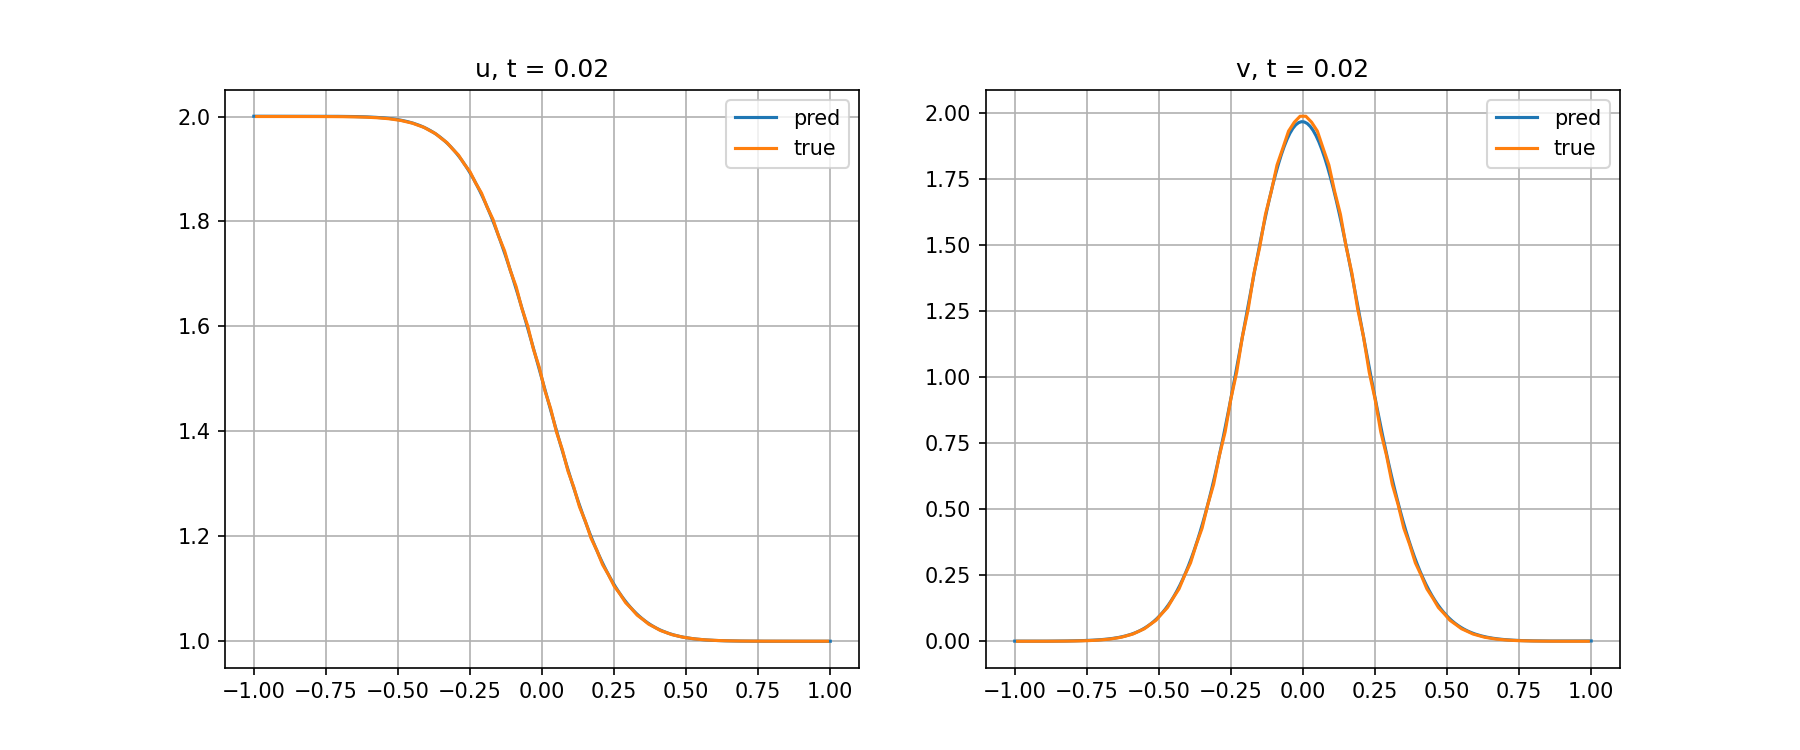

In [16]:
from scipy.io import loadmat
data = loadmat("epsilon_1e-12.mat")
x_true, u_true, v_true = data["x"], data["u"], data["v"]

f, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(x_test, u_preds[-1], label = "pred")
ax[0].plot(x_true, u_true, label = "true")
ax[0].set_title("u, t = {:.2f}".format(t_test[-1]))
ax[1].plot(x_test, v_preds[-1], label = "pred")
ax[1].plot(x_true, v_true, label = "true")
ax[1].set_title("v, t = {:.2f}".format(t_test[-1]))
for i in range(2):
	ax[i].legend()
	ax[i].grid()
plt.show()

In [ ]:
# x = jnp.linspace(*domain[:, 0], 10000).reshape((-1, 1))
# t = jnp.zeros_like(x)
# xt = jnp.hstack([x, t])


# # direct_params_ = direct_params
# direct_params_ = get_params(opt_state)
# duv_dxt = jacobian(direct_params_, xt)
# du_dt, dv_dt = duv_dxt[:, 0:1, 1], duv_dxt[:, 1:2, 1]
# du_dx, dv_dx = duv_dxt[:, 0:1, 0], duv_dxt[:, 1:2, 0]
# duv_dxxtt = hessian(direct_params_, xt)
# du_dxx, dv_dxx = duv_dxxtt[:, 0:1, 0, 0], duv_dxxtt[:, 1:2, 0, 0] 
# uv = model(direct_params_, xt)
# u, v = uv[:, 0:1], uv[:, 1:2]
# loss_c1 = epsilon*du_dt + 0.5*epsilon**2*dv_dxx - V*v
# loss_c2 = epsilon*dv_dt - 0.5*epsilon**2*du_dxx + V*u

# du0_dx, dv0_dx = du0_dx_fn(xt), dv0_dx_fn(xt)
# du0_dxx, dv0_dxx = du0_dxx_fn(xt), dv0_dxx_fn(xt)
# u0, v0 = u0_fn(xt[:, 0:1], xt[:, 1:2]), v0_fn(xt[:, 0:1], xt[:, 1:2])
# du0_dt = 1.0/epsilon*(V*v0 - epsilon**2/2*dv0_dxx)
# dv0_dt = 1.0/epsilon*(epsilon**2/2*du0_dxx - V*u0)
# loss_c10 = epsilon*du0_dt + 0.5*epsilon**2*dv0_dxx - V*v0
# loss_c20 = epsilon*dv0_dt - 0.5*epsilon**2*du0_dxx + V*u0

# %matplotlib inline
# plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams["text.usetex"] = True

# f, ax = plt.subplots(2, 5, figsize = (20, 10))
# i, j = 0, 0
# ax[i][j].plot(x, du_dt, label = "pred")
# ax[i][j].plot(x, du0_dt, label = "true")
# ax[i][j].set_title(r"$\frac{\partial u}{\partial t}$")
# i = 1
# ax[i][j].plot(x, dv_dt, label = "pred")
# ax[i][j].plot(x, dv0_dt, label = "true")
# ax[i][j].set_title(r"$\frac{\partial v}{\partial t}$")
# i, j = 0, j+1
# ax[i][j].plot(x, du_dx, label = "pred")
# ax[i][j].plot(x, du0_dx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial u}{\partial x}$")
# i = 1
# ax[i][j].plot(x, dv_dx, label = "pred")
# ax[i][j].plot(x, dv0_dx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial v}{\partial x}$")
# i, j = 0, j+1
# ax[i][j].plot(x, du_dxx, label = "pred")
# ax[i][j].plot(x, du0_dxx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial^2 u}{\partial x^2}$")
# i = 1
# ax[i][j].plot(x, dv_dxx, label = "pred")
# ax[i][j].plot(x, dv0_dxx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial^2 v}{\partial x^2}$")
# i, j = 0, j+1
# ax[i][j].plot(x, u, label = "pred")
# ax[i][j].plot(x, u0, label = "true")
# ax[i][j].set_title(r"$u$")
# i = 1
# ax[i][j].plot(x, v, label = "pred")
# ax[i][j].plot(x, v0, label = "true")
# ax[i][j].set_title(r"$v$")
# i, j = 0, j+1
# ax[i][j].plot(x, loss_c1, label = "pred")
# ax[i][j].plot(x, loss_c10, label = "true")
# ax[i][j].set_title(r"loss c1")
# i = 1
# ax[i][j].plot(x, loss_c2, label = "pred")
# ax[i][j].plot(x, loss_c20, label = "true")
# ax[i][j].set_title(r"loss c2")

# for i in range(2):
# 	for j in range(5):
# 		ax[i][j].legend()
# 		ax[i][j].grid()
# plt.show()

In [ ]:
get_params(opt_state)

In [ ]:
du_dxx

In [ ]:
du0_dx_fn(jnp.array([[-0.25, 0.0], [0.25, 0.0]]))